In [1]:
import sys
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn import preprocessing

sys.path.append("../")

In [2]:
from skimpy import skim
from tqdm import tqdm

In [3]:
from loguru import logger

log_dir = Path.cwd().parent / "logs"
logger.add(log_dir / "log.log")

1

In [4]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

## Prepare the data

In [5]:
MIN_MATCHES = 250
LAST_TRAIN_MATCH_DATE = datetime(2023, 7, 31)
this_dir = Path().resolve()
DATA_DIR = this_dir.parent / "data"
print(DATA_DIR)
df = pd.read_csv(DATA_DIR / "ml_rows.csv", parse_dates=["start_date"])

/home/mikew/extracover/data


#### Separate train/test sets

test data is the more recent set of matches - want to see how well the clusters produced match the outcomes from the data used in clustering

In [6]:
df_train = {
    inns: df[(df.start_date <= LAST_TRAIN_MATCH_DATE) & (df.match_number > MIN_MATCHES) & (df.innings == inns)]
    for inns in range(2)
}
df_test = {
    inns: df[(df.start_date > LAST_TRAIN_MATCH_DATE) & (df.match_number > MIN_MATCHES) & (df.innings == inns)]
    for inns in range(2)
}

train_dfs = {
    inns: {over: df_train[inns].loc[(df_train[inns]["over"] == over)] for over in range(20)} for inns in range(2)
}

In [7]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ Dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 1823454 │ │ float64     │ 9     │                                                         │
│ │ Number of columns │ 17      │ │ int64       │ 7     │                                                         │
│ └───────────────────┴─────────┘ │ datetime64  │ 1     │                                                         │
│                                 └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column          ┃ NA ┃ NA % ┃ mean    ┃ sd      ┃ p0       ┃ p25     ┃ p50     ┃ p75     ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ match_number    │  0 │    0 │    3958 │    2296 │        1 │    1965 │    3960 │    5938 │   7947 │ ██████ │  │
│ │ innings         │  0 │    0 │  0.4704 │  0.4991 │        0 │       0 │       0 │       1 │      1 │ █    ▇ │  │
│ │ ball_of_innings │  0 │    0 │   55.45 │   33.19 │        0 │      27 │      55 │      84 │    154 │ ██▇▇▃  │  │
│ │ over            │  0 │    0 │   8.998 │   5.622 │        0 │       4 │       9 │      14 │     19 │ █▆▆▆▅▆ │  │
│ │ wickets_down    │  0 │    0 │   2.593 │   2.165 │        0 │       1 │       2 │       4 │      9 │ █▄▆▂▂▁ │  │
│ │ run_rate        │  0 │    0 │   1.244 │  0.4386 │        0 │    1.01 │    1.25 │   1.477 │     14 │   █    │  │
│ │ req_rate        │  0 │    0 │  0.6965 │  0.8908 │        0 │       0 │       0 │   1.371 │      6 │  █▄▁   │  │
│ │ batter_in_first │  0 │    0 │  0.5402 │  0.4984 │        0 │       0 │       1 │       1 │      1 │ ▇    █ │  │
│ │ _10             │    │      │         │         │          │         │         │         │        │        │  │
│ │ batter_strike_r │  0 │    0 │   1.207 │  0.2107 │     0.04 │   1.124 │   1.227 │    1.33 │  4.091 │   █▁   │  │
│ │ ate             │    │      │         │         │          │         │         │         │        │        │  │
│ │ batter_dismissa │  0 │    0 │ 0.04973 │  0.0182 │ 0.005051 │ 0.03865 │ 0.04675 │ 0.05474 │   0.35 │   █▁   │  │
│ │ l_prob          │    │      │         │         │          │         │         │         │        │        │  │
│ │ batter_dismissa │  0 │    0 │ 0.05057 │ 0.02257 │ 0.004405 │ 0.03672 │ 0.04762 │ 0.05697 │    0.4 │   █▁   │  │
│ │ l_vs_style      │    │      │         │         │          │         │         │         │        │        │  │
│ │ bowler_economy  │  0 │    0 │    1.25 │  0.1818 │  0.07143 │   1.153 │   1.251 │   1.355 │      4 │   █▂   │  │
│ │ bowler_wicket_p │  0 │    0 │ 0.05087 │ 0.01376 │ 0.004762 │ 0.04348 │ 0.05134 │ 0.05651 │ 0.2432 │   ▃█   │  │
│ │ rob             │    │      │         │         │          │         │         │         │        │        │  │
│ │ bowler_wicket_v │  0 │    0 │ 0.05136 │ 0.01629 │ 0.004329 │ 0.04215 │ 0.05177 │ 0.05814 │ 0.2727 │   ▆█   │  │
│ │ s_style         │    │      │         │         │          │         │         │         │        │        │  │
│ │ bowler_wide_nob │  0 │    0 │  0.0361 │ 0.02271 │        0 │ 0.01997 │ 0.03495 │ 0.04651 │  0.375 │   █▁   │  │
│ │ all_rate        │    │      │         │         │   

In [8]:
def extract_values(d, values: list[str]):
    return d[values]


X_values = [
    "wickets_down",
    "run_rate",
    "req_rate",
    "batter_in_first_10",
    "batter_strike_rate",
    "batter_dismissal_prob",
    "batter_dismissal_vs_style",
    "bowler_economy",
    "bowler_wicket_prob",
    "bowler_wicket_vs_style",
    "bowler_wide_noball_rate",
]

y_values = [
    "outcome",
]

In [10]:
SCALER_CLASSES = {
    "quantile": preprocessing.QuantileTransformer(),
    "standard": preprocessing.StandardScaler(),
    "gaussian": preprocessing.QuantileTransformer(output_distribution="normal"),
    "normalizer": preprocessing.Normalizer(),
}


def prepare_training_set(inns, over, scaler: str) -> np.ndarray:
    X = extract_values(train_dfs[inns][over], X_values)
    scaler_obj = SCALER_CLASSES[scaler]
    fitted_scaler = scaler_obj.fit(X)
    return fitted_scaler.transform(X)


In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
from IPython.display import Markdown, display

## Estimate most effective numbers of clusters per innings, over

In [14]:
from kneed import KneeLocator


def test_n(n: int, X) -> float:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    return kmeans.inertia_


def find_knee(inns, over):
    X = prepare_training_set(inns, over, "quantile")
    clusters_range = range(11, 31, 1)
    sse = [test_n(n, X) for n in clusters_range]
    kneedle = KneeLocator(clusters_range, sse, curve="convex", direction="decreasing")
    return kneedle.knee


logger.info("finding knees...")

knees = {0: [], 1: []}

with tqdm(total=40) as pbar:
    for inns in range(2):
        for over in range(20):
            res = find_knee(inns, over)
            knees[inns].append(res)
        pbar.update()

for inns in range(2):
    print(inns, ",".join([f"{v}" for v in knees[inns]]))
    print(f"{inns} mean: {np.mean(knees[inns])}")

logger.info("done!")

2025-01-21 12:54:38.183 | INFO     | __main__:<module>:20 - finding knees...
 50%|█████     | 1/2 [01:37<01:37, 97.86s/it]

0 [np.int64(20), np.int64(22), np.int64(24), np.int64(19), np.int64(22), np.int64(20), np.int64(20), np.int64(11), np.int64(24), np.int64(22), np.int64(21), np.int64(24), np.int64(22), np.int64(23), np.int64(21), np.int64(26), np.int64(22), np.int64(17), np.int64(22), np.int64(23)]
0 mean: 21.25


100%|██████████| 2/2 [03:11<00:00, 95.68s/it]
2025-01-21 12:57:49.549 | INFO     | __main__:<module>:31 - done!


1 [np.int64(25), np.int64(22), np.int64(19), np.int64(21), np.int64(19), np.int64(23), np.int64(21), np.int64(19), np.int64(26), np.int64(22), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(12), np.int64(20), np.int64(24), np.int64(22), np.int64(22), np.int64(23)]
1 mean: 21.35


## Build clusters

Given a cluster count (in `knees`) fit each over's data

In [17]:
from collections import Counter

from hdbscan import flat

clfs: dict[int, list] = {0: [], 1: []}

logger.info("starting with estimated clusters...")
for scaler in [
    "normalizer",
]:  # ["standard", "quantile", "gaussian", "normalizer"]:
    for inns in range(2):
        for over in range(20):
            X_scaled = prepare_training_set(inns, over, scaler)
            n_clusters = knees[inns][over]
            clf = flat.HDBSCAN_flat(X_scaled, n_clusters=n_clusters)
            clf.fit(X_scaled)
            clfs[inns].append(clf)
            labels = clf.labels_
            clustered = labels >= 0
            counts = Counter(labels)
            total_clusters = np.max(labels) + 1
            coverage = np.sum(clustered) / X_scaled.shape[0]
            total_clusters = np.max(labels) + 1
            logger.info(
                f"{inns} {over} {n_clusters} {total_clusters} {coverage:.2%} pts:{len(labels)} noisy:{counts[-1]} {[v for k, v in counts.items() if k >= 0]}"
            )
logger.info("all done!")

2025-01-21 13:00:28.603 | INFO     | __main__:<module>:7 - starting with estimated clusters...
2025-01-21 13:00:47.303 | INFO     | __main__:<module>:24 - 0 0 20 20 97.71% pts:42259 noisy:966 [13992, 8662, 15589, 787, 1184, 283, 115, 590, 7, 9, 5, 7, 18, 9, 7, 6, 6, 6, 5, 6]
2025-01-21 13:00:59.534 | INFO     | __main__:<module>:24 - 0 1 22 22 96.70% pts:42104 noisy:1390 [29199, 9693, 227, 1281, 138, 6, 55, 11, 6, 9, 5, 11, 8, 14, 6, 8, 5, 6, 7, 5, 8, 6]
2025-01-21 13:01:12.431 | INFO     | __main__:<module>:24 - 0 2 24 24 99.01% pts:41705 noisy:414 [19115, 3865, 13560, 625, 3472, 73, 423, 38, 8, 8, 8, 6, 7, 6, 8, 13, 7, 9, 5, 6, 10, 7, 7, 5]
2025-01-21 13:01:25.160 | INFO     | __main__:<module>:24 - 0 3 19 19 98.98% pts:41627 noisy:424 [8119, 8816, 12389, 4951, 1229, 5420, 185, 6, 10, 8, 6, 10, 6, 10, 7, 7, 10, 6, 8]
2025-01-21 13:01:41.889 | INFO     | __main__:<module>:24 - 0 4 22 22 99.46% pts:41593 noisy:223 [9815, 9049, 10433, 6842, 2326, 2211, 560, 12, 5, 6, 9, 6, 13, 12, 19, 7

## Examine clustering outcomes

Run a T-SNE plot for the overs in an innings to get an impression of what kind of results we are getting. Use a sample to reduce execution time.

In [18]:
import seaborn as sns
from sklearn.manifold import TSNE

sns.set_theme(style="darkgrid", font_scale=0.5)

100%|██████████| 20/20 [04:49<00:00, 14.48s/it]


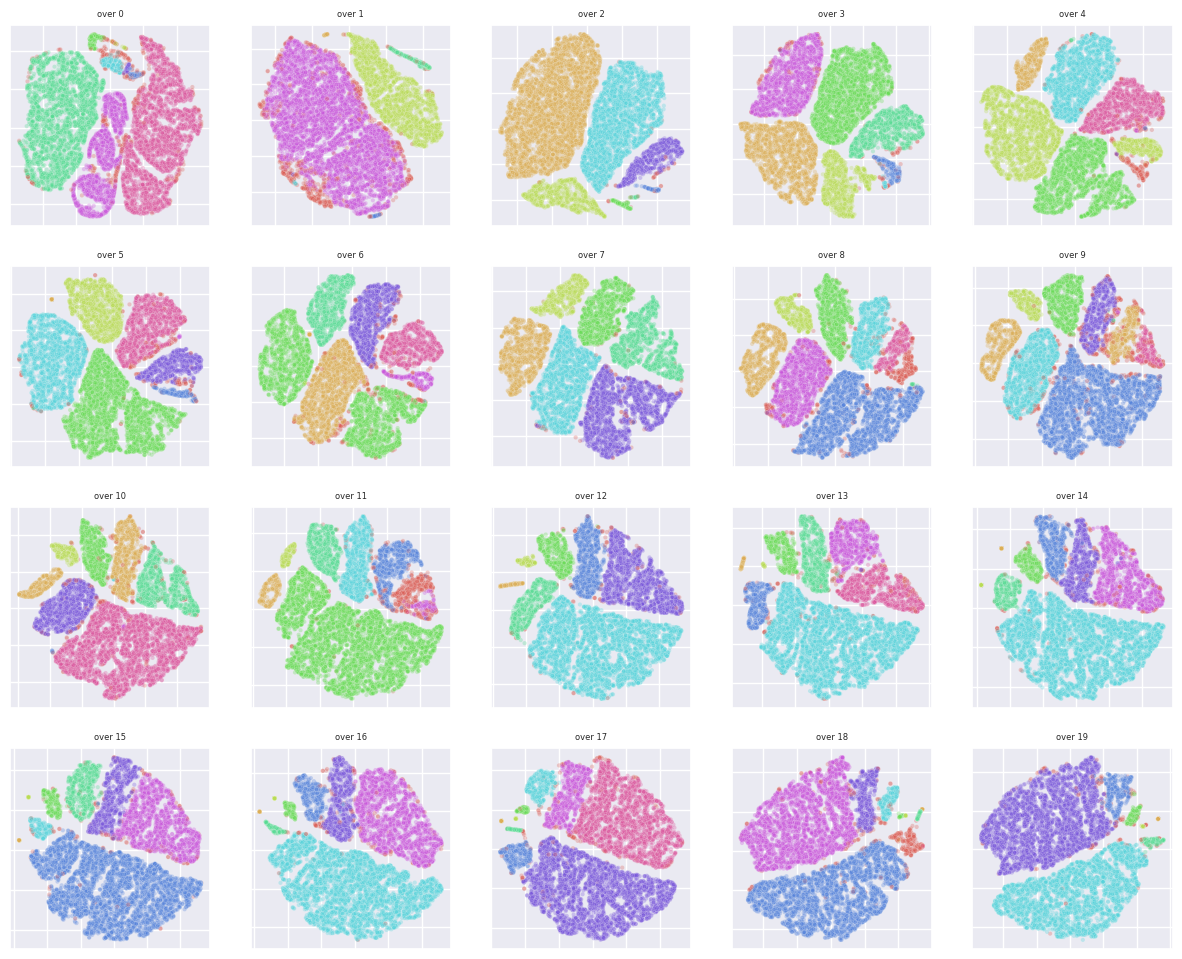

In [29]:
fig, axs = plt.subplots(4, 5, figsize=(15, 12))

inns = 0

for over in tqdm(range(20)):
    data = train_dfs[inns][over].sample(10000)

    X = extract_values(data, X_values)
    scaler_obj = SCALER_CLASSES["normalizer"]
    fitted_scaler = scaler_obj.fit(X)
    Xp = fitted_scaler.transform(X)

    tsne = TSNE(n_components=2, metric="euclidean", verbose=0, perplexity=40, n_iter=300)
    results = tsne.fit_transform(Xp)

    n_clusters = knees[inns][over]
    # clf = flat.HDBSCAN_flat(X, n_clusters=n_clusters)
    clf = clfs[inns][over]
    clf.fit(Xp)
    clfs[inns].append(clf)
    labels = clf.labels_

    df_res = pd.DataFrame()
    df_res["x"] = results[:, 0]
    df_res["y"] = results[:, 1]
    df_res["c"] = labels

    r = over % 5
    c = over // 5
    ax = axs[c, r]
    sns.scatterplot(
        x="x",
        y="y",
        data=df_res,
        hue="c",
        palette=sns.color_palette("hls", 10),
        legend=False,
        alpha=0.3,
        ax=ax,
        s=10,
    ).set(
        xticklabels=[],
        yticklabels=[],
        xlabel=None,
        ylabel=None,
        title=f"over {over}",
    )


## Apply clusterings - extract probabilities

In [32]:
from collections import defaultdict

In [88]:
inns, over = 0, 8
clf = clfs[inns][over]
Xt = extract_values(train_dfs[inns][over], X_values)
yt = extract_values(train_dfs[inns][over], y_values)
scaled_Xt = SCALER_CLASSES["normalizer"].fit(Xt).transform(Xt)
clf.fit(scaled_Xt)
labels = clf.labels_
outcomes = yt["outcome"]
outcomes.reset_index(drop=True, inplace=True)
print(len(labels), len(outcomes))

res = {k: defaultdict(int) for k in np.unique(labels)}
for i, label in enumerate(labels):
    res[label][outcomes[i]] += 1


40941 40941


In [89]:
OUTCOME_DESCS = [
    "label",
    "tot",
    "wide",
    "noball",
    "bye",
    "lebbye",
    "wicket",
    "dot",
    "single",
    "two",
    "three",
    "four",
    "six",
]

In [90]:
def title():
    return f"## Innings {inns}, Over {over}"


def table_hdr():
    return "\n".join(
        [
            "| " + " | ".join(OUTCOME_DESCS) + " |",
            "| " + " | ".join("---:" for _ in OUTCOME_DESCS) + " |",
        ]
    )


def table_line(k, v):
    tot = sum(v.values())
    return (
        f"| {k:-2d} | {tot:-6d} | "
        + " | ".join(f"{v[i] / tot:8.2%}" for i in range(np.unique(outcomes).shape[0]))
        + " |"
    )


body_lines = "\n".join(table_line(k, v) for k, v in res.items())

display(Markdown(title() + "\n" + table_hdr() + "\n" + body_lines))

## Innings 0, Over 8
| label | tot | wide | noball | bye | lebbye | wicket | dot | single | two | three | four | six |
| ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: | ---: |
| -1 |    461 |    3.47% |    0.22% |    0.65% |    1.30% |    7.16% |   35.57% |   39.48% |    5.86% |    0.43% |    4.56% |    1.30% |
|  0 |      6 |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |   66.67% |    0.00% |    0.00% |    0.00% |    0.00% |   33.33% |
|  1 |   3565 |    2.50% |    0.31% |    0.36% |    0.93% |    5.86% |   20.76% |   44.40% |    7.55% |    0.39% |   10.01% |    6.93% |
|  2 |  22010 |    2.46% |    0.27% |    0.25% |    1.13% |    4.36% |   25.16% |   46.52% |    6.92% |    0.34% |    8.07% |    4.52% |
|  3 |      7 |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |  100.00% |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |
|  4 |      6 |    0.00% |    0.00% |    0.00% |    0.00% |   16.67% |   33.33% |   16.67% |   33.33% |    0.00% |    0.00% |    0.00% |
|  5 |      9 |   11.11% |    0.00% |    0.00% |    0.00% |    0.00% |   66.67% |   11.11% |    0.00% |    0.00% |   11.11% |    0.00% |
|  6 |      8 |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |   37.50% |   50.00% |   12.50% |    0.00% |    0.00% |    0.00% |
|  7 |   5001 |    1.94% |    0.16% |    0.24% |    1.10% |    3.58% |   31.57% |   44.75% |    6.60% |    0.28% |    7.12% |    2.66% |
|  8 |   4432 |    1.99% |    0.11% |    0.14% |    1.08% |    3.45% |   35.36% |   44.47% |    5.84% |    0.18% |    5.55% |    1.83% |
|  9 |   2117 |    1.46% |    0.19% |    0.38% |    1.09% |    3.68% |   29.85% |   46.62% |    6.05% |    0.38% |    6.38% |    3.92% |
| 10 |     14 |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |   42.86% |   50.00% |    0.00% |    0.00% |    7.14% |    0.00% |
| 11 |      8 |   12.50% |   12.50% |    0.00% |    0.00% |    0.00% |   25.00% |   25.00% |   12.50% |    0.00% |   12.50% |    0.00% |
| 12 |      6 |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |   33.33% |   50.00% |   16.67% |    0.00% |    0.00% |    0.00% |
| 13 |      6 |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |   50.00% |   33.33% |    0.00% |    0.00% |   16.67% |    0.00% |
| 14 |      6 |    0.00% |    0.00% |    0.00% |    0.00% |   16.67% |   66.67% |    0.00% |    0.00% |    0.00% |   16.67% |    0.00% |
| 15 |      6 |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |   50.00% |   16.67% |   16.67% |    0.00% |   16.67% |    0.00% |
| 16 |      6 |   16.67% |    0.00% |    0.00% |    0.00% |    0.00% |   66.67% |    0.00% |   16.67% |    0.00% |    0.00% |    0.00% |
| 17 |     11 |   18.18% |    0.00% |    0.00% |    0.00% |    9.09% |   54.55% |    0.00% |    0.00% |    0.00% |    9.09% |    9.09% |
| 18 |     10 |   10.00% |    0.00% |    0.00% |    0.00% |    0.00% |   60.00% |   20.00% |   10.00% |    0.00% |    0.00% |    0.00% |
| 19 |     11 |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |   81.82% |   18.18% |    0.00% |    0.00% |    0.00% |    0.00% |
| 20 |      6 |    0.00% |    0.00% |    0.00% |    0.00% |    0.00% |   66.67% |    0.00% |    0.00% |    0.00% |   33.33% |    0.00% |
| 21 |   1050 |    2.86% |    0.19% |    0.10% |    0.76% |    5.33% |   46.38% |   33.33% |    3.24% |    0.29% |    6.10% |    1.43% |
| 22 |      9 |    0.00% |   22.22% |    0.00% |    0.00% |    0.00% |   22.22% |   33.33% |   22.22% |    0.00% |    0.00% |    0.00% |
| 23 |   2170 |    2.26% |    0.18% |    0.14% |    0.83% |    3.59% |   39.86% |   41.38% |    5.12% |    0.23% |    4.52% |    1.89% |